In [597]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
sns.set_style("whitegrid")

In [598]:
data = pd.read_csv("results/properties.csv")

In [599]:
data

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space
0,5 bedroom detached duplex for sale,"Ikate, Lekki, Lagos","₦750,000,000",5.0,5.0,6.0,NaN
1,4 bedroom detached duplex for sale,"Oral Estate, Ikota, Lekki, Lagos","₦180,000,000",4.0,5.0,5.0,NaN
2,3 bedroom block of flats for sale,"Gra Estate, Abijo, Lekki, Lagos","₦85,000,000",3.0,3.0,3.0,2.0
3,6 bedroom detached duplex for sale,"Pinnock Beach Estate, Osapa, Lekki, Lagos","₦1,500,000,000",6.0,7.0,7.0,NaN
4,5 bedroom detached duplex for sale,"Osapa, Lekki, Lagos","₦350,000,000",5.0,5.0,6.0,NaN
...,...,...,...,...,...,...,...
80684,2 bedroom flat / apartment for sale,"Donatus Odum Street, Seagate Estate, Ikate Ele...","₦130,000,000",2.0,2.0,3.0,2.0
80685,6 bedroom detached duplex for sale,"Apo, Abuja","₦570,000,000",6.0,7.0,7.0,10.0
80686,4 bedroom terraced duplex for sale,"Plot 134, Ayodele Odubiyi Street, Pinnacle Gas...","₦1,200,000,000",4.0,16.0,20.0,12.0
80687,3 bedroom flat / apartment for sale,"Off Oladipo Diya Road, Gaduwa, Abuja","₦180,000,000",3.0,3.0,4.0,2.0


In [600]:
data.shape

(80689, 7)

In [601]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80689 entries, 0 to 80688
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_of_house  80689 non-null  object 
 1   location       80689 non-null  object 
 2   price          80689 non-null  object 
 3   bedrooms       58725 non-null  float64
 4   bathrooms      51543 non-null  float64
 5   toilets        53044 non-null  float64
 6   parking_space  33765 non-null  float64
dtypes: float64(4), object(3)
memory usage: 4.3+ MB


In [602]:
data.describe()

,bedrooms,bathrooms,toilets,parking_space
count,58725.000000,51543.000000,53044.000000,33765.000000
mean,4.982937,4.794288,5.511293,93.360107
std,85.141716,19.130627,11.537307,6027.323821
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,4.000000,3.000000
50%,4.000000,4.000000,5.000000,4.000000
75%,5.000000,5.000000,6.000000,5.000000
max,20540.000000,3157.000000,2000.000000,1000000.000000


### Data Cleaning and Normalization

Firstly, it would be more suitable to pull out the `state` and `town` from the location column

In [603]:
data["location"].str.split(",").str[-2].value_counts()

location
 Lekki          26624
 Ajah            4868
 Ikeja           4322
 Ikoyi           4217
Ajah             2926
                ...  
Uruan               1
 Ikot Ekpene        1
 Awgu               1
 Ilesa East         1
 Idemili            1
Name: count, Length: 448, dtype: int64

In [604]:
data[data["location"].str.contains("lagos")]

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space
6048,Filling station for sale,"Hammadiyah B/stop,lagos-abeokuta Express, Ageg...","₦600,000,000",NaN,NaN,NaN,NaN
10090,Commercial property for sale,"Ibadan-lagos Express Way, Ojodu Berger, Ojodu,...","₦750,000,000",NaN,NaN,NaN,NaN
18118,Residential land for sale,"Beside First Technical University,lagos Expres...","₦25,000,000",NaN,NaN,NaN,NaN
23022,5 bedroom detached duplex for sale,"Osapa,lekki,lagos, Osapa, Lekki, Lagos","₦300,000,000",5.0,5.0,6.0,3.0
27831,5 bedroom detached duplex for sale,"Orchid Hotel Road ,lagos Ocean Bay Estate, Lek...","₦380,000,000",5.0,5.0,6.0,3.0
31112,4 bedroom detached duplex for sale,"Ajah ,lagos, Ajah, Lagos","₦120,000,000",4.0,5.0,5.0,3.0
37586,12 bedroom house for sale,"Isihor Egbaen, Off Ugbowo-lagos Road, Benin, O...","₦50,000,000",12.0,NaN,NaN,NaN
53401,Industrial land for sale,"Km 8, Abeokuta-lagos Expressway, Ile-ise Awo B...","₦100,000,000",NaN,NaN,NaN,NaN
53911,Land for sale,Close To Oke Ogun Tennis Mins Off Abeokuta-lag...,"₦900,000",NaN,NaN,NaN,NaN
56077,Land for sale,Few Mins Off Abeokuta-lagos Road Close To Ace ...,"₦900,000",NaN,NaN,NaN,NaN


In [605]:
# To remove all white spaces
data["location"] = data["location"].str.strip().replace(r'\s+', ' ', regex=True)
data["location"] = data["location"].str.replace(r'\s*,\s*', ', ', regex=True)

In [606]:
def split_location(location):
    """Splits location into state and town."""
    try:
        parts = location.rsplit(",", 2)  # Split from right, max 2 splits
        state = parts[-1].strip()
        town = parts[-2].strip()
        return state, town
    except IndexError:
        # Handle cases with missing state or town
        return None, None

This line of code takes the `location` column, applies the split_location function to extract the state and town into tuples, unpacks those tuples into separate columns using pd.Series, and then assigns those columns to the "state" and "town" columns of the original DataFrame data.

In [607]:
data[["state", "town"]] = data["location"].apply(split_location).apply(pd.Series)

In [608]:
data['state'] = data['state'].str.title()
data['town'] = data['town'].str.title()

In [609]:
len(data["state"].unique())

31

In [610]:
data[~data["price"].str.contains("₦")]

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space,state,town
158,2 bedroom flat / apartment for sale,"Tm Highgardens, Harbour Lights District, Eko A...","$270,000",2.0,2.0,3.0,2.0,Lagos,Eko Atlantic City
328,6 bedroom house for sale,"Old Ikoyi, Ikoyi, Lagos","$2,500,000",6.0,NaN,6.0,NaN,Lagos,Ikoyi
334,Mixed-use land for sale,"Ahmadu Bello Way, Victoria Island (VI), Lagos","$4,000,000,000",NaN,NaN,NaN,NaN,Lagos,Victoria Island (Vi)
343,3 bedroom flat / apartment for sale,"Marion Apartment, Banana Island, Ikoyi, Lagos","$1,300,000",3.0,3.0,4.0,NaN,Lagos,Ikoyi
344,5 bedroom detached duplex for sale,"Banana Island, Ikoyi, Lagos","$1,500,000",5.0,5.0,6.0,NaN,Lagos,Ikoyi
...,...,...,...,...,...,...,...,...,...
80657,5 bedroom detached duplex for sale,"3rd Avenue, Banana Island, Ikoyi, Lagos","$4,000,000",5.0,5.0,6.0,NaN,Lagos,Ikoyi
80662,6 bedroom detached duplex for sale,"Naf Valley Estate, Asokoro District, Abuja","$550,000",6.0,6.0,7.0,3.0,Abuja,Asokoro District
80670,6 bedroom detached duplex for sale,"Naf Valley Estate, Asokoro District, Abuja","$550,000",6.0,6.0,7.0,3.0,Abuja,Asokoro District
80672,5 bedroom detached duplex for sale,"3rd Avenue, Banana Island, Ikoyi, Lagos","$4,000,000",5.0,5.0,6.0,NaN,Lagos,Ikoyi


In [611]:
data.iloc[48141]

type_of_house    Block of flats for sale
location          Sangotedo, Ajah, Lagos
price                            Unknown
bedrooms                             NaN
bathrooms                            NaN
toilets                              NaN
parking_space                        NaN
state                              Lagos
town                                Ajah
Name: 48141, dtype: object

Converting all dollar denominated pricing to naira

In [612]:
import re

In [613]:
def convert_price(price):
    """
    converts price from string to float.
    And also converts dollar prices to naira.
    """
    if "₦" in price:
        price = price.replace("₦", "").replace(",", "")
        return float(price)
    elif "$" in price:
        price = price.replace("$", "").replace(",", "")
        return float(price) * 1500
    else:
        return None

In [614]:
data["price"] = data["price"].apply(convert_price)

In [615]:
data = data[~data["price"].isna()]

Detecting and removing outliers

In [616]:
data = data[data["bedrooms"] < 20]
data = data[data["bathrooms"] < 20]
data = data[data["toilets"] < 20]
data = data[data["parking_space"] < 20]

<Axes: >

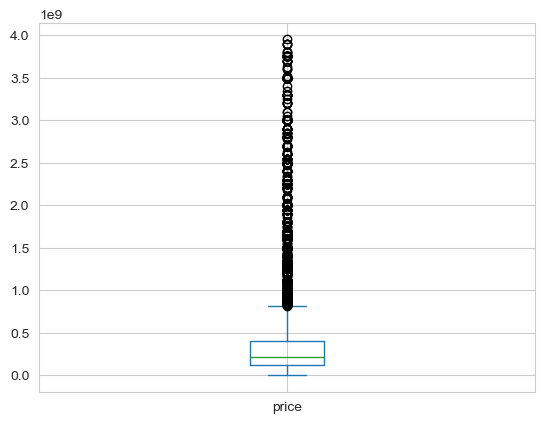

In [628]:
data["price"].plot(kind="box")

<Axes: >

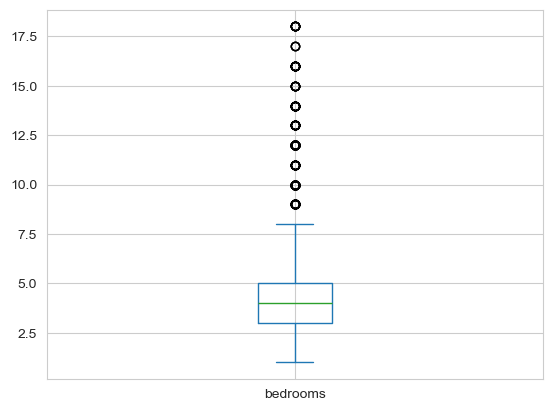

In [618]:
data["bedrooms"].plot(kind="box")

In [629]:
data.describe() 

,price,bedrooms,bathrooms,toilets,parking_space
count,2.892500e+04,28925.000000,28925.000000,28925.000000,28925.000000
mean,3.557791e+08,4.019741,4.201971,4.983198,3.934071
std,4.614652e+08,1.365276,1.465787,1.511170,2.277654
min,1.000000e+05,1.000000,1.000000,1.000000,1.000000
25%,1.200000e+08,3.000000,3.000000,4.000000,2.000000
50%,2.200000e+08,4.000000,4.000000,5.000000,3.000000
75%,4.000000e+08,5.000000,5.000000,6.000000,5.000000
max,3.950000e+09,18.000000,18.000000,19.000000,19.000000


In [622]:
data[data["bedrooms"] > 10]

,type_of_house,location,price,bedrooms,bathrooms,toilets,parking_space,state,town
399,12 bedroom detached bungalow for sale,"Gwarimpa Main By 3rd Avenue, Gwarinpa, Abuja",4.500000e+08,12.0,12.0,18.0,15.0,Abuja,Gwarinpa
1154,14 bedroom detached duplex for sale,"Off Ligali Ayorinde Street, Victoria Island La...",2.400000e+09,14.0,16.0,18.0,15.0,Lagos,Victoria Island (Vi)
2320,13 bedroom semi-detached duplex for sale,"Mercy Land Extension, Rumuigbo, Port Harcourt,...",2.500000e+08,13.0,17.0,17.0,10.0,Rivers,Port Harcourt
2552,12 bedroom block of flats for sale,"Short Drive From Ojodu Berger, Arepo, Magboro,...",6.500000e+07,12.0,12.0,17.0,6.0,Ogun,Magboro
4022,12 bedroom detached duplex for sale,"Gra, Back Of Excellence Hotel, Ogba, Ikeja, Lagos",5.000000e+08,12.0,12.0,14.0,10.0,Lagos,Ikeja
...,...,...,...,...,...,...,...,...,...
77749,12 bedroom detached duplex for sale,"Guzape District, Abuja",1.200000e+09,12.0,13.0,13.0,10.0,Abuja,Guzape District
77779,12 bedroom block of flats for sale,"Agbede Village Funaab, Abeokuta South, Ogun",2.000000e+07,12.0,12.0,12.0,4.0,Ogun,Abeokuta South
78038,12 bedroom block of flats for sale,"Alafara, Ologuneru, Ibadan, Oyo",1.200000e+08,12.0,12.0,16.0,8.0,Oyo,Ibadan
79728,12 bedroom detached bungalow for sale,"Adeyefa Estate, Iyana Ipaja, Ipaja, Lagos",3.500000e+07,12.0,12.0,13.0,10.0,Lagos,Ipaja


<Axes: >

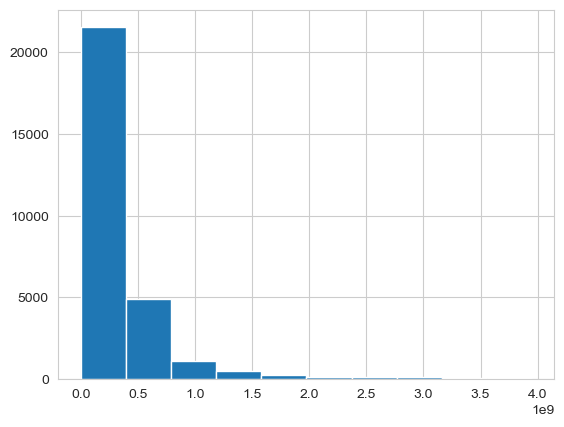

In [627]:
data["price"].hist()

In [624]:
data = data[data["price"] < 4000000000]

<Axes: >

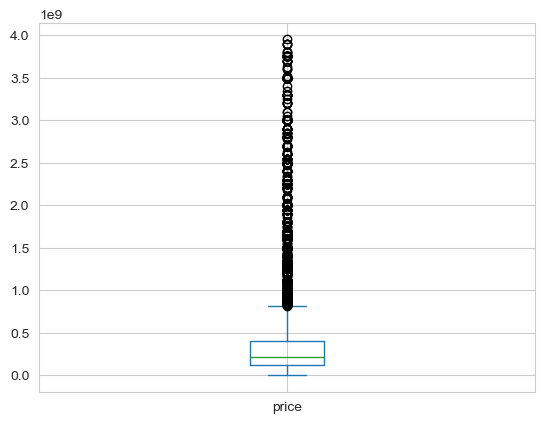

In [625]:
data["price"].plot(kind="box")

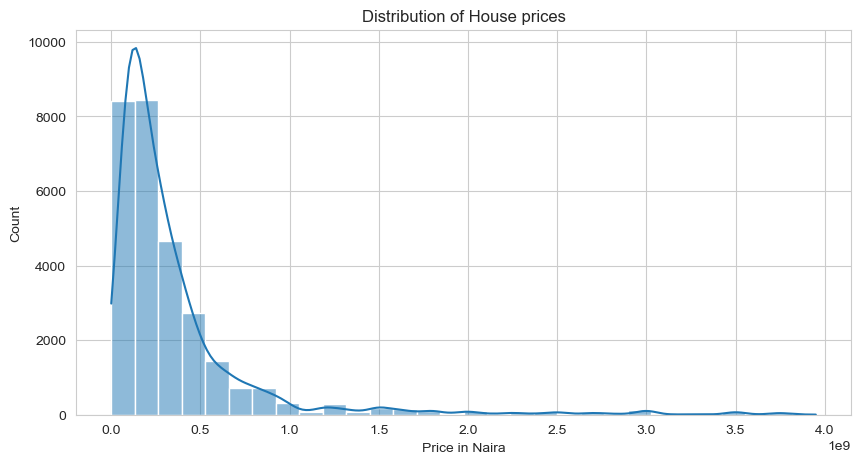

In [626]:
plt.figure(figsize=(10, 5))
sns.histplot(data["price"], bins=30, kde=True)
plt.title("Distribution of House prices")
plt.xlabel("Price in Naira")
plt.show()

In [630]:
data['price_log'] = np.log1p(data['price'])

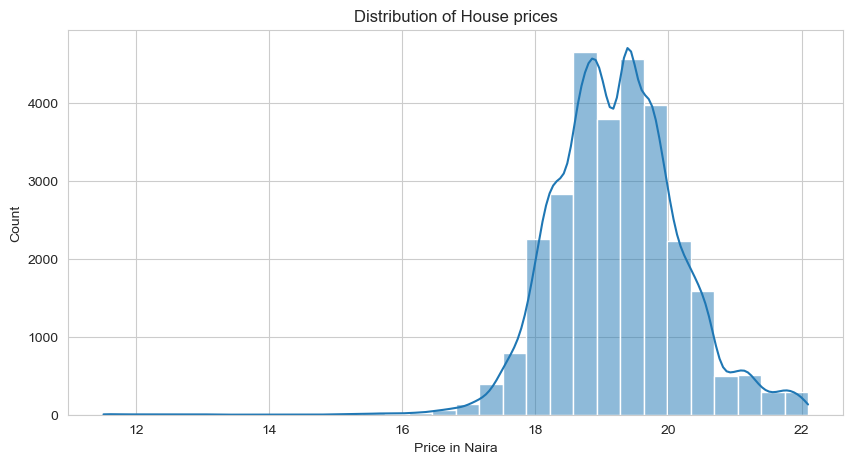

In [632]:
plt.figure(figsize=(10, 5))
sns.histplot(data["price_log"], bins=30, kde=True)
plt.title("Distribution of House prices")
plt.xlabel("Price in Naira")
plt.show()

In [633]:
data.describe()


,price,bedrooms,bathrooms,toilets,parking_space,price_log
count,2.892500e+04,28925.000000,28925.000000,28925.000000,28925.000000,28925.000000
mean,3.557791e+08,4.019741,4.201971,4.983198,3.934071,19.228304
std,4.614652e+08,1.365276,1.465787,1.511170,2.277654,0.938352
min,1.000000e+05,1.000000,1.000000,1.000000,1.000000,11.512935
25%,1.200000e+08,3.000000,3.000000,4.000000,2.000000,18.603002
50%,2.200000e+08,4.000000,4.000000,5.000000,3.000000,19.209138
75%,4.000000e+08,5.000000,5.000000,6.000000,5.000000,19.806975
max,3.950000e+09,18.000000,18.000000,19.000000,19.000000,22.096981


In [634]:
data["type_of_house"] = data["type_of_house"].str.replace(" for sale", "")